In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp # segmentation_models_pytorch has been provided in the repo
import timm # you need timm (torch image models) to run this
import cv2
import torchvision.transforms as T
from torchvision import transforms
import torchvision.models as models
from PIL import Image
import random
import os
import copy
from tqdm import tqdm
import torch.optim as optim
#from torch.utils.tensorboard import SummaryWriter # tensorboard is needed if you want to log your results




This project requires you to install timm (torch image models). Importantly, run all the imports above. If you want to use this notebook please install timm using either pip or anaconda. Otherwise, the usual libraries (matplotlib, numpy, pytorch, torchvision, cv2) have been used. 

If you want to **test** some of the models I've trained, run all cells below the heading "Testing Code". 
If you want to train any models using the code here, install albumentations as well. 
 

In [5]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

Define class for validation dataset: 

In [8]:
from torchvision.transforms import functional as F
from torch.utils.data import Dataset
import random

import albumentations as A
from albumentations.pytorch import ToTensorV2

val_transforms = A.Compose([
    A.Resize(768, 768),
    A.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),  
    ToTensorV2()
])


class TestValData(Dataset):
    def __init__(self, img_path, mask_path, transforms):
        self.img_path = img_path
        self.mask_path = mask_path
        self.masks = sorted([
            f for f in os.listdir(mask_path)
        ])
        self.images = sorted([
            f for f in os.listdir(img_path)
        ])
        self.file_count = len(self.masks)
        self.transforms = transforms
    
    def __len__(self):
        return self.file_count
    def __getitem__(self, index):
        image_name = self.images[index]
        mask_name = self.masks[index]
        
        full_img_path  = os.path.join(self.img_path,  image_name)
        full_mask_path = os.path.join(self.mask_path, mask_name)
        
        image = cv2.imread(full_img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(full_mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask >= 50).astype(np.float32)
        
        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]
            
        image = image.float()
        mask  = mask.float()

        return image, mask
    

Define geometric augmentations (crops etc.) to perform on both the image and the mask together using albumentations

In [10]:
train_geo_augs = A.Compose([
    A.Resize(768, 768),
    A.RandomCrop(400, 400),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    ToTensorV2()
])
train_img_augs = A.Compose([A.GaussNoise(var_limit=(5.0, 15.0), p=0.5), 
                            A.Normalize(mean=[0.485, 0.456, 0.406], 
                                        std=[0.229, 0.224, 0.225])])


class TrainingData(Dataset):
    def __init__(self, img_path, mask_path, geo_augs, img_augs, NUM_CROPS = 10):
        self.img_path = img_path
        self.mask_path = mask_path
        self.NUM_CROPS = NUM_CROPS
        self.masks = sorted([
            f for f in os.listdir(mask_path)
        ])
        self.images = [f.replace("mask", "image").replace(".png", ".tif") for f in os.listdir(mask_path)]
        self.file_count = len(self.masks)
        self.geo_augs = geo_augs
        self.img_augs = img_augs
    def __len__(self):
        return self.file_count*self.NUM_CROPS

    def __getitem__(self, index):
        idx = index // self.NUM_CROPS 
        image_name = self.images[idx]
        mask_name = self.masks[idx]
        
        full_img_path  = os.path.join(self.img_path,  image_name)
        full_mask_path = os.path.join(self.mask_path, mask_name)
                
        image = cv2.imread(full_img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
         
        mask = cv2.imread(full_mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask >= 50).astype(np.float32)

        if self.img_augs:
            image = self.img_augs(image=image)["image"]
        if self.geo_augs:
            augmented = self.geo_augs(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        image = image.float()
        mask  = mask.float()

        return image, mask


C:\Users\krish\AppData\Local\Temp\ipykernel_20984\3117046332.py:9: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  train_img_augs = A.Compose([A.GaussNoise(var_limit=(5.0, 15.0), p=0.5),


Load the pretrained model from SMP:

In [14]:
### import a pretrained U-Net model with a ResNet34 encoder, trained on ImageNet

model = smp.Unet(encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=1)

model = model.to(device)

In [15]:
#Change training batch size depending on your VRAM specs. Mine is 6GB, so unfortunately 16 is plenty
batch_size = 16
numcrops = 20

# the folder data/ contains all the training and validation data. Testing data is optional if you want to add it
train_imgs = "data/images-train/"
train_masks = "data/masks-train/"
test_imgs = "data/images-test/"
test_masks = "data/masks-test/"
val_imgs = "data/images-val/"
val_masks = "data/masks-val/"

train_dataset = TrainingData(train_imgs, train_masks, train_geo_augs, train_img_augs, NUM_CROPS=numcrops)
val_dataset = TestValData(val_imgs, val_masks, val_transforms)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0, 
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
)

Optional code to visualise the dataset:

In [19]:
# Displays all the images and masks in the training dataset
def show_all_images_and_masks(dataset, max_items=None):
    n = len(dataset) if max_items is None else min(max_items, len(dataset))
    
    for i in range(n):
        img, mask = dataset[i]
        if hasattr(img, "numpy"):  
            img = img.permute(1, 2, 0).numpy() 
        if hasattr(mask, "numpy"):
            mask = mask.squeeze().numpy() 

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f'Image #{i}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Mask #{i}')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# show_all_images_and_masks(train_dataset, max_items=150)

In [21]:
# verify shape of inputs and masks

train_imgs, train_masks = next(iter(train_loader))
print(f"Image batch shape: {train_imgs.size()}")
print(f"Mask batch shape: {train_masks.size()}")

val_imgs, val_masks = next(iter(val_loader))
print(f"Image batch shape: {val_imgs.size()}")
print(f"Mask batch shape: {val_masks.size()}")

Image batch shape: torch.Size([16, 3, 400, 400])
Mask batch shape: torch.Size([16, 400, 400])
Image batch shape: torch.Size([13, 3, 768, 768])
Mask batch shape: torch.Size([13, 768, 768])


Training loop and validation code:

In [23]:
#training loop
def train_fn(train_loader, val_loader, test_loader, model, optimizer, scaler, epoch, best_val_loss, best_dict, l1,l2, writerobj=None):
    model.train()
    loop = tqdm(train_loader, desc = f"Epoch {epoch}")
    total_train_loss = 0
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.unsqueeze(1).to(device=DEVICE)

        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = 0.5*l1(predictions, targets) + 0.5*l2(predictions, targets)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()        
        loop.set_postfix(loss=loss.item())
        
    avg_train_loss = total_train_loss / len(train_loader)
    if writerobj:
        writerobj.add_scalar('training, FT20: ', avg_train_loss, epoch)
    
    # Evaluate using validation dataset and BCE loss
    val_loss = evaluate(val_loader, model, nn.BCEWithLogitsLoss())
    if best_val_loss > val_loss:
        best_val_loss = val_loss
        best_dict = copy.deepcopy(model.state_dict())
    if writerobj:
        writerobj.add_scalar('validation, FT20: ', val_loss, epoch)
    
    print(f"\nEpoch {epoch} Summary:")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"val loss: {val_loss}")
    print(f"Best val loss: {best_val_loss}")
    return best_val_loss, best_dict

# validation code
def evaluate(loader, model, loss_fn):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device=DEVICE)
            targets = targets.unsqueeze(1).to(device=DEVICE)
            
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            total_loss += loss.item()

    model.train()
    return total_loss / len(loader)



### Training Code

In [25]:
from segmentation_models_pytorch.losses import TverskyLoss, DiceLoss, FocalLoss
from torch.utils.tensorboard import SummaryWriter

LEARNING_RATE = 1e-4
DEVICE = "cuda"
NUM_EPOCHS = 15
l1 = TverskyLoss(mode='binary')
l2 = FocalLoss(mode='binary')
scaler = torch.cuda.amp.GradScaler()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
best_val_loss = 10000000
best_dict = None
def train():
    writer = None # SummaryWriter(log_dir="runs/loss functions") 
    for epoch in range(NUM_EPOCHS):
        best_val_loss, best_dict = train_fn(train_loader, val_loader, test_loader, model, optimizer, scaler, epoch, best_val_loss, best_dict, l1,l2, writer)
    writer.close()
    model.load_state_dict(best_dict)
    return 
# Optional: train a model
# train()

C:\Users\krish\AppData\Local\Temp\ipykernel_20984\1235401022.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


### Testing Code

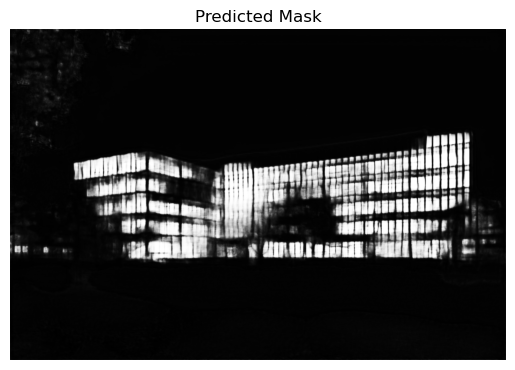

In [27]:
# Test the model on a variety of online images
model = smp.Unet(encoder_name="resnet34", in_channels=3, classes=1)
model.to('cuda')
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Load the checkpoint
checkpoint = torch.load("trained_models/FT15.pth", map_location=torch.device('cuda'))

# Restore model and optimizer state
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
img_name = "hanna neumann"

img = Image.open(f"External example images/{img_name}.jpeg").convert("RGB")
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])])

input_img = transform(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(input_img)  

output_img = output.sigmoid().squeeze().detach().cpu().numpy()  # shape: [H, W]
# If you want to binarise:
# output_img[output_img > 0.3] = 255
# output_img[output_img <= 0.3] = 0

plt.imshow(output_img, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')
# Optional: save result
#plt.savefig(f"FT15{img_name}.png", bbox_inches='tight', pad_inches=0)
plt.show()

In [28]:
def save_checkpoint(model, optimizer, epoch, path='trained_models/my model.pth'):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved to {path}")

#save_checkpoint(model, optimizer, NUM_EPOCHS)
